# Error Characterization of HERMES (Micro)
Understanding the sources of error of an integrator is essential for many reasons. It makes debugging much faster, adding new modules much easier, and operation more efficient.

In this example we investigate how the error of HERMES behaves during both close encounters and collisions. As we will see, this can reveal great insight. It is important to note that the energy we track over time is purely numerical in nature. The physical energy lost during any collisions has been scaled out. 

In [1]:
import rebound
import numpy as np

## Setup
In this problem we simulate a star, planet and 4 planetesimals on orbit-crossing trajectories with the planet. We then investigate two situations:  
1) Successive near-miss: All 4 planetesimals have near-misses (or super close encounters) with the planet.  
2) Successive hit: All 4 planetesimals collide with the planet.

In [2]:
def problem(HSR, hit, orbitplot):
    sim = rebound.Simulation()
    
    #integrator options
    sim.integrator = "hybarid"
    sim.ri_hybarid.switch_radius = HSR
    sim.ri_hybarid.CE_radius = 20.
    sim.dt = 0.001
    sim.testparticle_type = 1
    sim.usleep = -1
    tmax = 5.5

    #collision and boundary options
    sim.collision = "direct"
    sim.collision_resolve = "merge"
    sim.collisions_track_dE = 1
    
    #massive bodies
    sim.add(m=1,r=0.005)
    sim.add(m=1e-5,r=1.6e-4,a=0.5,e=0.1,inc=0,f=0)
    
    sim.N_active = sim.N
    
    #planetesimals
    m = 1e-9
    a = [0.1,0.2,0.3,0.3]
    e = [0.4,0.4,0.3,0.8]
    omega = [0,0,np.pi,np.pi]
    f_hit = [-0.94,2.6748,1.828,1.953]
    f_miss = [-0.91,2.67,1.83,1.951]
    if hit == 1:
        f = f_hit
    else:
        f = f_miss
    for i in xrange(0,len(a)):
        sim.add(m=m,r=4e-5,a=sim.particles[1].x+a[i],e=e[i],omega=omega[i],f=f[i])
    
    #final physics initialization stuff
    sim.move_to_com()
    E0 = sim.calculate_energy()

    #optional orbit plot
    if orbitplot == 1:
        %matplotlib inline
        fig = rebound.OrbitPlot(sim, trails=True)
    
    #output initialization 
    n_outputs = 1000
    times = np.linspace(0,tmax,n_outputs)
    dE = np.zeros(n_outputs)
    
    for i,t in enumerate(times):
        sim.integrate(t)
        dE[i] = abs((sim.calculate_energy() - E0)/E0)
    
    return times, dE, sim.N

Great, Now let's run the code for both situations, and output a visualization for the near-miss situation.

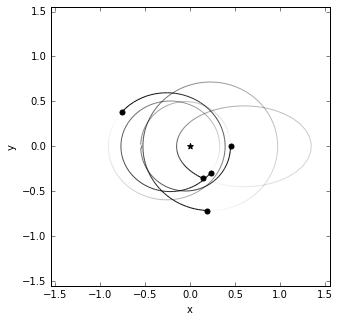

In [7]:
HSR = 3
time_miss, dE_miss, N_miss = problem(HSR,0,1)
time_hit, dE_hit, N_hit = problem(HSR,1,0)

Now let's plot the results.

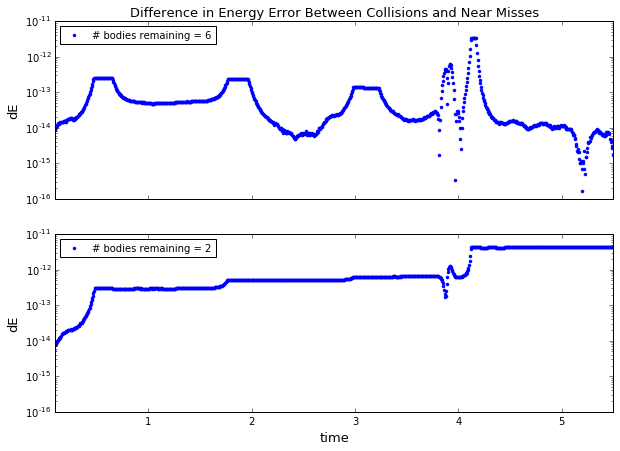

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,7))
plt.subplots_adjust(wspace=0.3)
fontsize=13
axes[0].plot(time_miss,dE_miss,'.',label="# bodies remaining = %d"%N_miss)
axes[0].set_title("Difference in Energy Error Between Collisions and Near Misses",fontsize=fontsize)
axes[0].set_xlim([0.1,max(time_miss)])
axes[0].set_ylabel('dE',fontsize=fontsize)
axes[0].set_yscale('log')
axes[0].legend(loc="upper left",prop={'size':10},numpoints=1)
axes[1].plot(time_hit,dE_hit,'.',label="# bodies remaining = %d"%N_hit)
axes[1].set_yscale('log')
axes[1].set_ylabel('dE',fontsize=fontsize)
axes[1].set_xlabel("time",fontsize=fontsize)
axes[1].legend(loc="upper left",prop={'size':10},numpoints=1)

## Analysis
These two plots reveal a lot about HERMES.  

The first plot shows the "successive near-miss" example, and we see a unique set of "top-hat" energy spikes. These energy spikes correspond to physical close encounters between the planet and planetesimals. The height of these energy spikes is determined by the ratio of the system's interaction and keplerian hamiltonians (i.e. $\epsilon$ to the expert), which is set by the value of our Hybrid Switch Ratio ($HSR$). The smaller $HSR$ is, the larger these spikes will be (try it out!). The energy spike is flat on top because here the IAS15 is integrating the system to machine precision (introducing $\sim 10^{-16}$ errors which won't show up). Lastly, you will notice that after a close encounter the energy error doesn't return exactly to its intial value. It turns out the exact energy of the Wisdom-Holman scheme is dependent upon both physical and numerical parameters ($dt$, orbit phases, etc.), and changing these parameters (i.e. switching to and from the IAS15 during a close encounter) leads to a random change in energy. Over the long term this will manifest as a $t^{1/2}$ random walk in the energy growth, which is the best one can hope for.  

The second plot shows the "successive hit" example, and instead of seeing the same "top-hat" energy spikes we instead see successive energy gains by the integrator. This is a source of bias for the current implementation of HERMES, and will lead to $>t^{1/2}$ energy growth. For most applications this is not a significant source of error, and as long as the final energy error of the simulation is $<10^{-4}$ or so (representing a 0.1% error in the semi-major axis) the final results should be trustworthy.